# Прогнозирование уровня удовлетворённости сотрудников и их оттока 

Компания **«Работа с заботой»** стремится минимизировать финансовые риски и снизить отток сотрудников. Для этого были предоставлены данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Необходимо помочь бизнесу:  
1. **Предсказать уровень удовлетворённости работой**
2. **Прогнозировать риск увольнения**



## Задача 1: предсказание уровня удовлетворённости сотрудника

### Описание данных
- `id` — уникальный идентификатор сотрудника
- `dept` — отдел, в котором работает сотрудник
- `level` — уровень занимаемой должности
- `workload` — уровень загруженности сотрудника
- `employment_years` — длительность работы в компании (в годах)
- `last_year_promo` — показывает, было ли повышение за последний год
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель
- `salary` — ежемесячная зарплата сотрудника
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [93]:
#!pip install -r requirements.txt

In [94]:
import os
import phik
import optuna
import logging
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, r2_score

from optuna.integration import OptunaSearchCV
from optuna import distributions
from optuna import Trial

from tqdm.auto import tqdm
from functools import partial

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING) 
RANDOM_STATE = 42

### Загрузка данных

In [95]:
# функция проверки наличия датасета
def get_dataset(path_1, path_2, sep=','): 
    if os.path.exists(path_1):
        return parse_dataset(path_1, sep)
    elif os.path.exists(path_2):
        return parse_dataset(path_2, sep)
    else:
        print('Произошла ошибка')


# функция для парсинга таблицы с отображением ее свойств
def parse_dataset(path, sep):
    df = pd.read_csv(path, sep=sep)
    display(df.head())
    display((df.isna().mean()).sort_values(ascending=False).to_frame(name='Процент пропусков'))
    df.info()
    
    return df

In [96]:
# функция отображения уникальных значений качественных признаков
def unique_category(df):
    for clmn in df.select_dtypes(exclude='number'):
        if df[clmn].nunique() <= 20:
            print(clmn+":", df[clmn].unique(), end='\n\n')

In [97]:
path_1 = '/datasets/train_job_satisfaction_rate.csv'
path_2 = './datasets/train_job_satisfaction_rate.csv'

train_job_satisfaction = get_dataset(path_1, path_2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,Процент пропусков
dept,0.0015
level,0.0010
id,0.0000
workload,0.0000
employment_years,0.0000
last_year_promo,0.0000
last_year_violations,0.0000
supervisor_evaluation,0.0000
salary,0.0000
job_satisfaction_rate,0.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [98]:
unique_category(train_job_satisfaction)

dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

level: ['junior' 'middle' 'sinior' nan]

workload: ['medium' 'high' 'low']

last_year_promo: ['no' 'yes']

last_year_violations: ['no' 'yes']



В таблице **`train_job_satisfaction`** присутствуют пропуски в признаках `dept` и `level`. \
`last_year_promo`, `last_year_violations` - бинарные признаки

In [99]:
path_1 = '/datasets/test_features.csv'
path_2 = './datasets/test_features.csv'

test_features = get_dataset(path_1, path_2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,Процент пропусков
dept,0.0010
level,0.0005
id,0.0000
workload,0.0000
employment_years,0.0000
last_year_promo,0.0000
last_year_violations,0.0000
supervisor_evaluation,0.0000
salary,0.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [100]:
unique_category(test_features)

dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

level: ['junior' 'middle' 'sinior' nan]

workload: ['medium' 'low' 'high' ' ']

last_year_promo: ['no' 'yes']

last_year_violations: ['no' 'yes']



В таблице **`test_features`**, как и в **`train_job_satisfaction`** присутствуют пропуски в столбцах `dept` и `level`. Также в таблице есть неизвестные категории в виде пробелов в признаках `dept`, `workload`.

In [101]:
path_1 = '/datasets/test_target_job_satisfaction_rate.csv'
path_2 = './datasets/test_target_job_satisfaction_rate.csv'

test_target = get_dataset(path_1, path_2)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


,Процент пропусков
id,0.0
job_satisfaction_rate,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Целевой столбец тестового датасета имеет другой порядок наблюдений, необходимо будет соединить датасеты по столбцу id

#### Вывод загрузки датасетов

В таблицах **`test_features`** и **`train_job_satisfaction`** присутствуют пропуски в столбцах `dept` и `level`. \
В таблице **`test_features`** есть неизвестные категории в виде пробелов в признаках `dept`, `workload`.

### Предобработка данных

#### Поиск дубликатов

In [102]:
print('количество дубликатов в таблице train_job_satisfaction:', train_job_satisfaction.duplicated(subset='id').sum())
print('количество дубликатов в таблице test_features:', test_features.duplicated(subset='id').sum())

количество дубликатов в таблице train_job_satisfaction: 0
количество дубликатов в таблице test_features: 0


Все сотрудники в таблицах уникальны, дубликатов не обнаружено.

#### Замена пропусков

In [103]:
categorical_features = ['dept', 'level']

In [104]:
fill_na_cat = Pipeline([
    ('simple_imputer_cat',
    SimpleImputer(strategy='most_frequent'))]
)

In [105]:
preliminary_preprocessor = ColumnTransformer(
    [
        ('fill_na_cat', fill_na_cat, categorical_features)
    ], 
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

Пайплайн для замены пропусков на чаще всего встречаемые значения в признаках.

##### Тренировочный датасет

In [106]:
lst_tjs_na =  train_job_satisfaction.query('dept.isna() or level.isna()')['id'].to_list()
train_job_satisfaction.query('id in @lst_tjs_na')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [107]:
lst_columns_train = train_job_satisfaction.columns.tolist() # Порядок столбцов прошлой таблицы

train_job_satisfaction = preliminary_preprocessor.fit_transform(train_job_satisfaction)[lst_columns_train]
train_job_satisfaction.query('id in @lst_tjs_na')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,junior,medium,1,no,no,4,27600,0.66
1469,416327,sales,junior,low,1,no,no,5,18000,0.73
1526,694746,sales,junior,medium,5,no,no,4,21600,0.62
1630,814624,sales,junior,medium,3,no,no,4,24000,0.88
1633,475114,sales,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,junior,medium,1,no,no,3,26400,0.30
2522,998838,sales,junior,medium,1,no,no,5,27600,0.71
2781,497243,sales,junior,medium,1,no,no,3,26400,0.28
2975,168668,sales,junior,low,3,no,no,4,18000,0.88
3866,641150,sales,junior,low,3,no,yes,4,12000,0.54


Пропуски в столбцах `dept`, `level` таблицы **`train_job_satisfaction`** были заменены на значения моды.

##### Тестовый датасет

In [108]:
lst_tf_na =  test_features.query('dept.isna() or level.isna()')['id'].to_list()
test_features.query('id in @lst_tf_na')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [109]:
test_features = preliminary_preprocessor.fit_transform(test_features)[lst_columns_train[:-1]]

test_features.query('id in @lst_tf_na')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,sales,junior,medium,1,no,no,1,20400
312,471990,sales,junior,low,1,no,no,3,12000
1196,832342,sales,junior,medium,1,no,no,4,28800


Пропуски в столбцах `dept`, `level` таблицы **`test_features`** были заменены на значения моды.

#### Вывод предобработки данных

1. Дубликаты отсутствуют
2. Пропуски категориальных признаков были заменены, ипользуя пайплайн, на значения моды

Неизвестные категории, такие как ' ' в тестовой выборке, будут обрабатываться в итоговом пайплайне.

### Исследовательский анализ данных

In [110]:
# Функция для отображения гистограммы всех признаков
def plt_hist(df):
    plt.figure(figsize=(22, 10))
    i = 1
    num_columns = df.select_dtypes(include='number').columns[1:]
    cat_columns = df.select_dtypes(exclude='number').columns
    
    # числовые 
    for clm_n in num_columns:
        plt.subplot(3, 3, i)
        if df[clm_n].nunique() <= 20:
            axes = sns.countplot(data=df.iloc[:, 1:], x=clm_n, color='#1F77B4') 
        else:
            axes = sns.histplot(data=df.iloc[:, 1:], x=clm_n)
        axes.set_ylabel('количество')
        i += 1

    # категориальные
    for clm_c in cat_columns:
        plt.subplot(3, 3, i)
        axes = sns.countplot(data=df, x=clm_c, color='#1F77B4')
        axes.set_ylabel('количество')
        i += 1

#### Тренировочный датасет

In [111]:
train_job_satisfaction.iloc[:, 1:].describe(include='all')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
count,4000,4000,4000,4000.000000,4000,4000,4000.000000,4000.000000,4000.000000
unique,5,3,3,NaN,2,2,NaN,NaN,NaN
top,sales,junior,medium,NaN,no,no,NaN,NaN,NaN
freq,1518,1898,2066,NaN,3880,3441,NaN,NaN,NaN
mean,NaN,NaN,NaN,3.718500,NaN,NaN,3.476500,33926.700000,0.533995
std,NaN,NaN,NaN,2.542513,NaN,NaN,1.008812,14900.703838,0.225327
min,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,0.030000
25%,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,0.360000
50%,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,0.560000
75%,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,0.710000


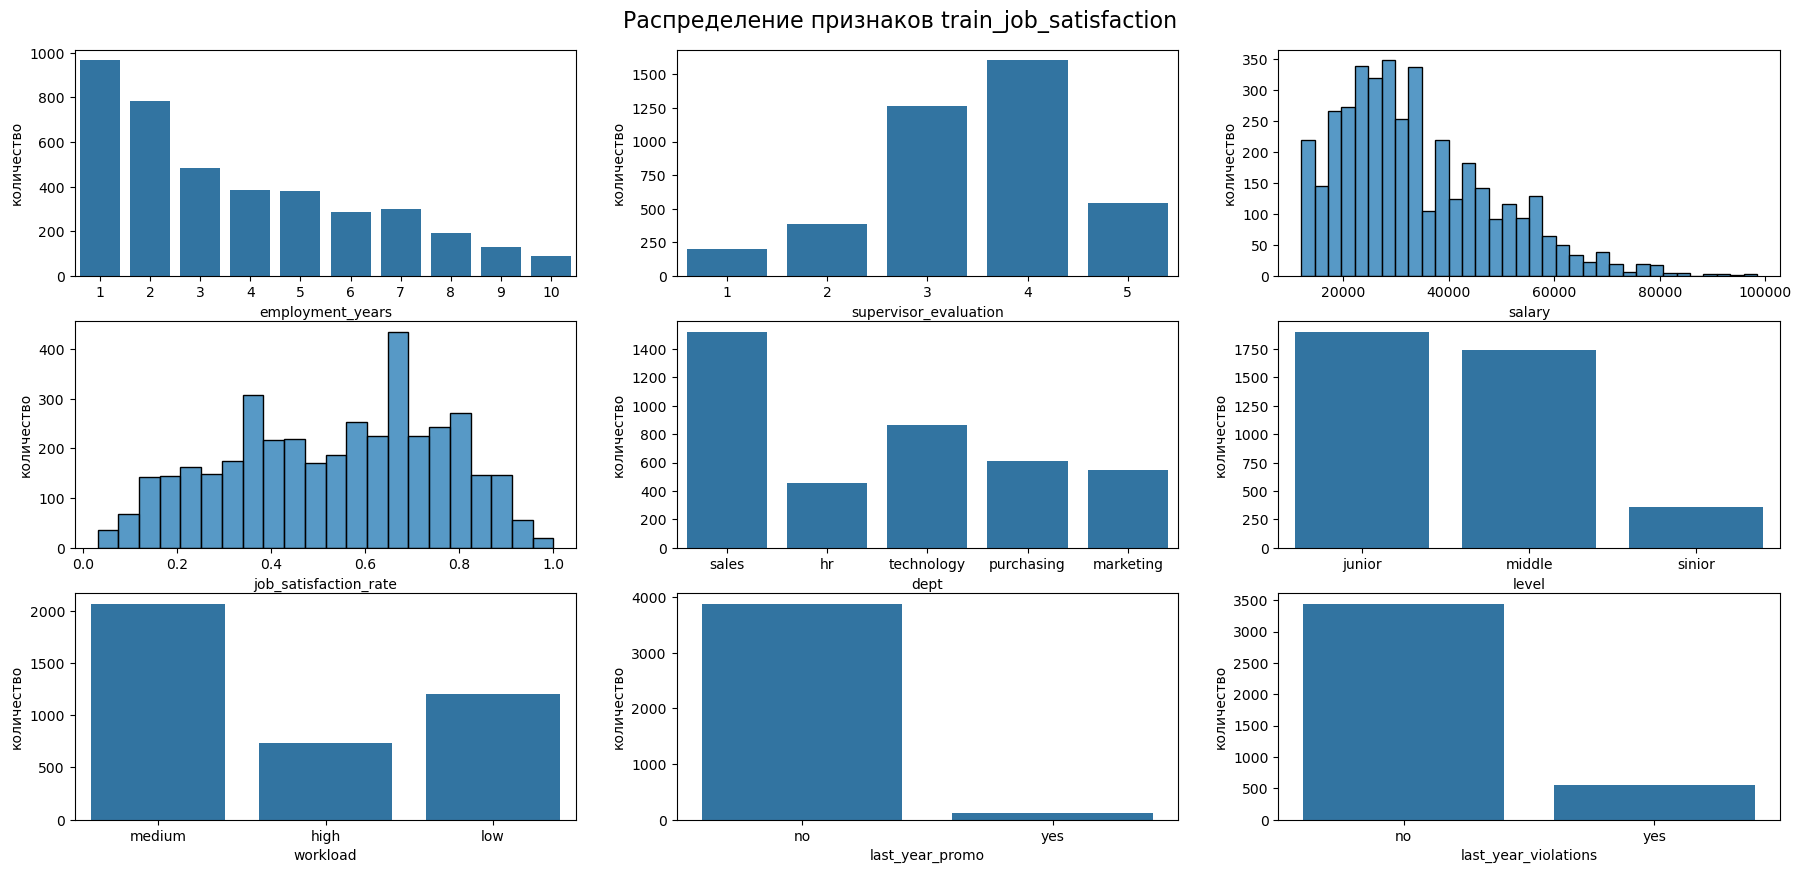

In [112]:
plt_hist(train_job_satisfaction)
plt.suptitle('Распределение признаков train_job_satisfaction', y=0.92, fontsize=16)
plt.show()

За последний год в компании у 120 (3%) сотрудников было повышение, 559 (14%) сотрудников нарушали трудовой договор. \
Чаще всего сотрудники имеют уровни занимаемой должности 'junior' - 47% и 'middle' - 44% и имеют среднюю загруженность - в 52% наблюдений. \
75% сотрудников работают в компании менее 6 лет. \
113 сотрудников имеют минимальную зароботную плату - 12000. \
Отдел 'sales' имеет наибольшее количество сотрудников - 1518. 

#### Тестовый датасет

In [113]:
test_job_satisfaction = pd.merge(test_features, test_target, on='id', how='inner')
print('Количество пропусков после слияния:', test_job_satisfaction['job_satisfaction_rate'].isna().sum())

Количество пропусков после слияния: 0


После склейки входных признаков с целевым тестового датасета пропусков не появилось.

In [114]:
test_job_satisfaction.iloc[:, 1:].describe(include='all')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
count,2000,2000,2000,2000.000000,2000,2000,2000.000000,2000.000000,2000.00000
unique,6,3,4,NaN,2,2,NaN,NaN,NaN
top,sales,junior,medium,NaN,no,no,NaN,NaN,NaN
freq,765,975,1043,NaN,1937,1738,NaN,NaN,NaN
mean,NaN,NaN,NaN,3.666500,NaN,NaN,3.526500,34066.800000,0.54878
std,NaN,NaN,NaN,2.537222,NaN,NaN,0.996892,15398.436729,0.22011
min,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,0.03000
25%,NaN,NaN,NaN,1.000000,NaN,NaN,3.000000,22800.000000,0.38000
50%,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,0.58000
75%,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,0.72000


Признаки `dept` и `workload` в тестовом датасете имеет на одну категорию больше, чем тренировочный датасет

In [115]:
print('dept:', test_job_satisfaction['dept'].unique().tolist())
print('workload:', test_job_satisfaction['workload'].unique().tolist())

dept: ['marketing', 'hr', 'sales', 'purchasing', 'technology', ' ']
workload: ['medium', 'low', 'high', ' ']


Оба признака имеют дополнительные значения в виде пробелов. Обработаем такой случай в пайплайне и заменим пробелы на самые частые значения фич.

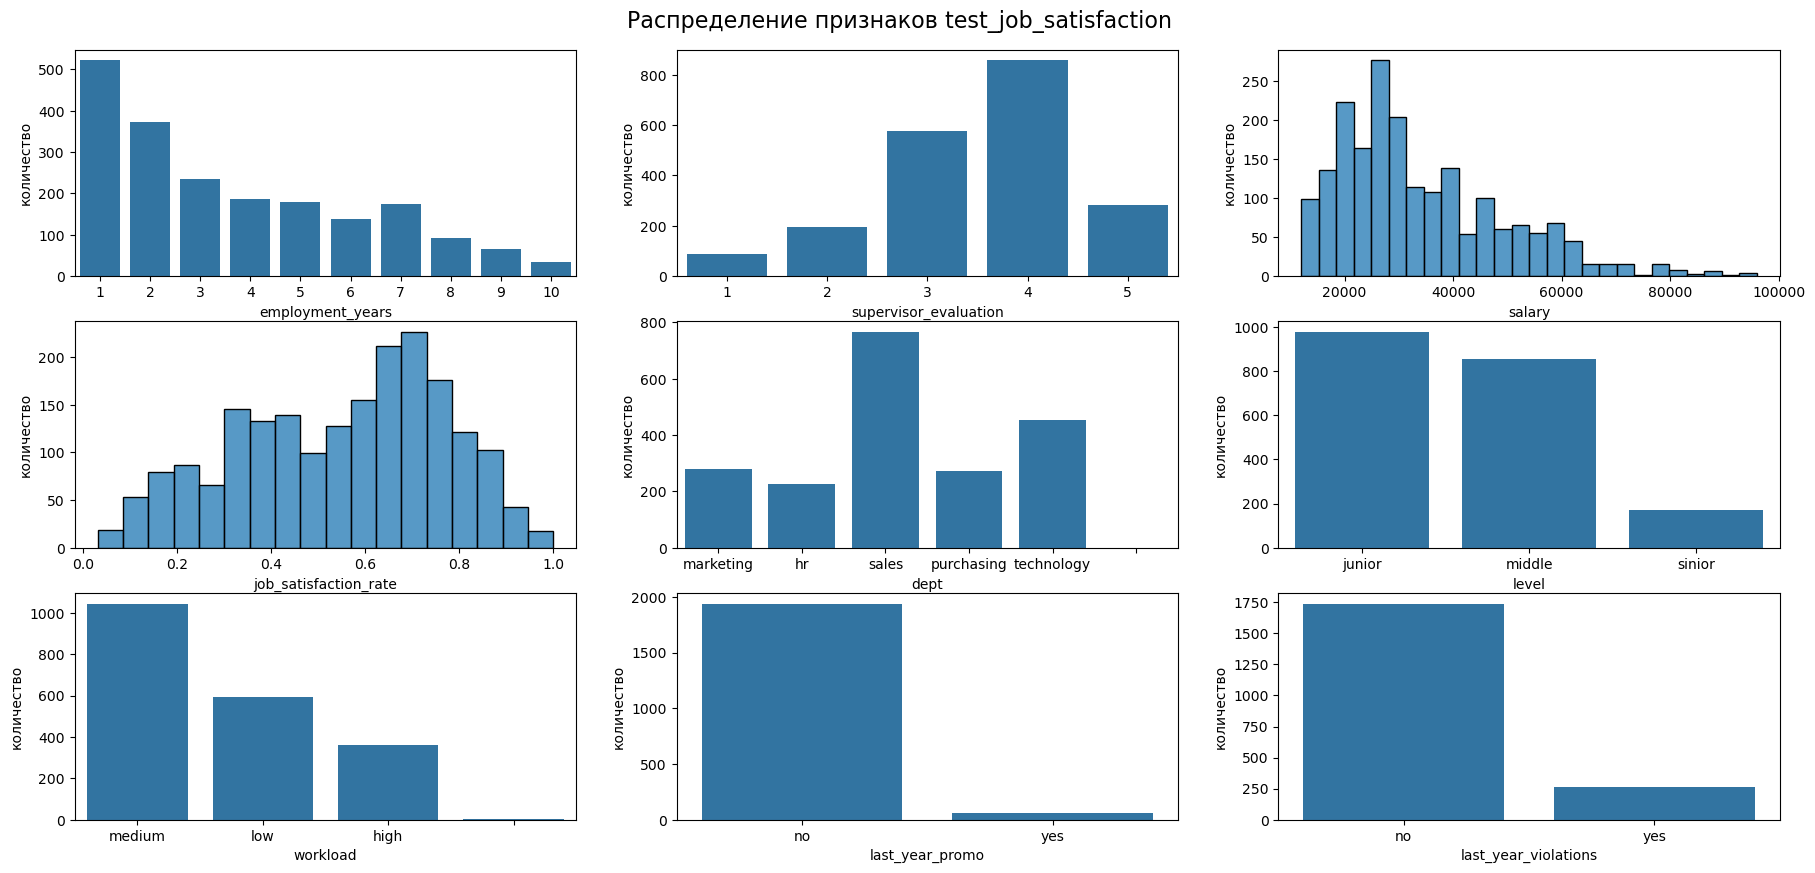

In [116]:
plt_hist(test_job_satisfaction)
plt.suptitle('Распределение признаков test_job_satisfaction', y=0.92, fontsize=16)
plt.show()

In [117]:
print('Количество тестовых данных в тренировочных:', \
      len(train_job_satisfaction.query(f'id in {test_features["id"].tolist()}')))

Количество тестовых данных в тренировочных: 0


Статистически тестовые данные имеют очень близкие распределения к тренировочным. Следовательно тренировочные данные будут релевантными для обучения моделей. Утечки в данных нет.

#### Корреляционный анализ

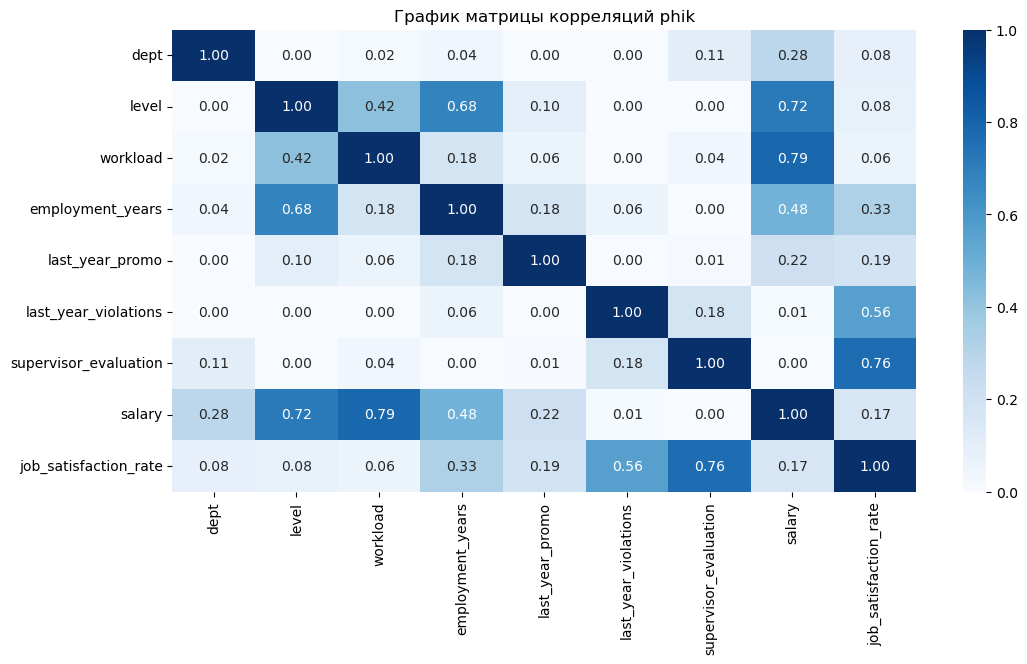

In [118]:
plt.figure(figsize=(12, 6))
plt.title('График матрицы корреляций phik')
sns.heatmap(train_job_satisfaction.iloc[:, 1:].phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']),
            annot=True,
            fmt='.2f',
            cmap='Blues');

1. Мультиколлениарность
    1. Высокая:
        - `workload` и `salary` - 0.79
        - `level` и `salary` - 0.72
    2. Заметная:
        - `level` и `employment_years` - 0.68
    3. Умеренная:
        - `employment_years` и `salary` - 0.48
        - `level` и `workload` - 0.42


2. Корреляция с целевым
    - `supervisor_evaluation` - 0.76
    - `last_year_violations` - 0.56
    - `employment_years` - 0.33


Оценка руководителя тесно связана с удовлетворенностью сотрудника. Можно добавить в форму опроса сотрудников оценку их отношений с руководителем. Возможно, это даст лучшее понимание связи признаков.

#### Вывод исследовательского анализа

1. Порядковые категориальные:
    - `employment_years`
    - `last_year_promo`
    - `last_year_violations`
    - `supervisor_evaluation`
    - `level`
    - `workload`

2. Количественные непрерывные:
    - `salary`

3. Номинальные категориальные:
    - `dept`

Два признака тестового датасета (**`test_job_satisfaction`**) имеют дополнительные значения в виде пробелов. Необходимо учесть возможные неизвестные значения в пайплайне.

Для линейных моделей важны упорядоченные и неупорядоченные признаки, поэтому необходимо использовать правильную технику кодирования, чтобы не создавать линейные зависимости там, где их нет \
Упорядоченные данные стоит подготавливать с помощью OrdinalEncoder с указанием ранга \
Неупорядоченные стоит подготавливать с помощью OneHotEncoder

### Подготовка данных и обучение модели

In [119]:
X_train = train_job_satisfaction.drop(['id', 'job_satisfaction_rate', 'salary'], axis=1) 
y_train = train_job_satisfaction['job_satisfaction_rate']

X_test = test_job_satisfaction.drop(['id', 'job_satisfaction_rate', 'salary'], axis=1)
y_test = test_job_satisfaction['job_satisfaction_rate']

In [120]:
ord_cols = ['last_year_promo', 'last_year_violations', 'level', 'workload']
scaled_cols = ['employment_years']
ohe_cols = ['dept']

Определены признаки под правильную технику кодирования, мультиколлениарный признак удален из датасетов.

In [121]:
pipe_ohe = Pipeline([
    ('simpleImputer_ohe',
    SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ('ohe',
    OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

pipe_ord = Pipeline([
    ('simpleImputer_before_ord',
    SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value',
                           unknown_value=np.nan,
                            categories=[['no', 'yes'],
                                        ['no', 'yes'],
                                        ['junior', 'middle', 'sinior'],
                                        ['low', 'medium', 'high']])),
    
    ('simpleImputer_after_ord',
    SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

В пайплайне предобрабатываются возможные пропуски, которые не были определены в `preliminary_preprocessor`

In [122]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', pipe_ohe, ohe_cols),
        ('ord', pipe_ord, ord_cols),
        ('scaled', MinMaxScaler(), scaled_cols)
    ],
    remainder='passthrough'
)


pipe_final = Pipeline([
    ('fillna', preliminary_preprocessor),
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

Определен итоговый пайплайн с предварительной предобработкой, подготовкой количественных и категориальных признаков.

In [123]:
# метрика SMAPE
def smape_metric(y_true, y_pred):
    numerator = 2 * np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred))

    return  100 * np.mean(numerator / denominator) 


smape_score = make_scorer(smape_metric, greater_is_better=False)

In [124]:
# Графики остатков
def residuals_plot(predictions, residuals):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(residuals, kde=True)
    plt.title('Гистограмма распределения остатков')
    plt.ylabel('остатки')

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=predictions, y=residuals)
    sns.regplot(x=predictions, y=residuals, order=2)
    plt.title('Анализ дисперсии')
    plt.xlabel('предсказание')
    plt.ylabel('остатки')

    plt.show()

#### Модель линейной регрессии

Метрика SMAPE на тестовой выборке: 25.63
Кэффициент детерминации: 0.62


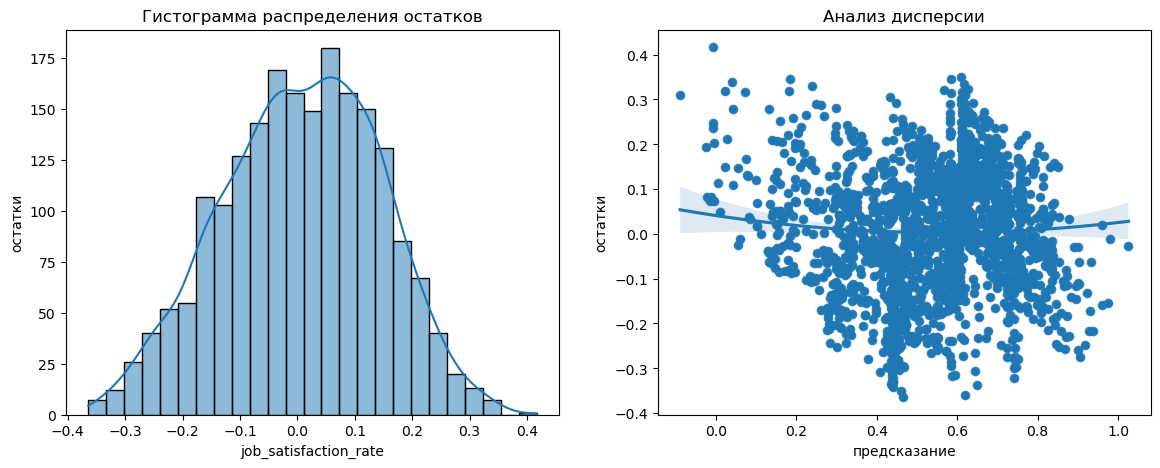

In [125]:
pipe_final.fit(X_train, y_train)
y_pred = pipe_final.predict(X_test)

print('Метрика SMAPE на тестовой выборке:', round(smape_metric(y_test, y_pred), 2))
print('Кэффициент детерминации:', round(r2_score(y_test, y_pred), 2))
residuals_plot(y_pred, y_test - y_pred)

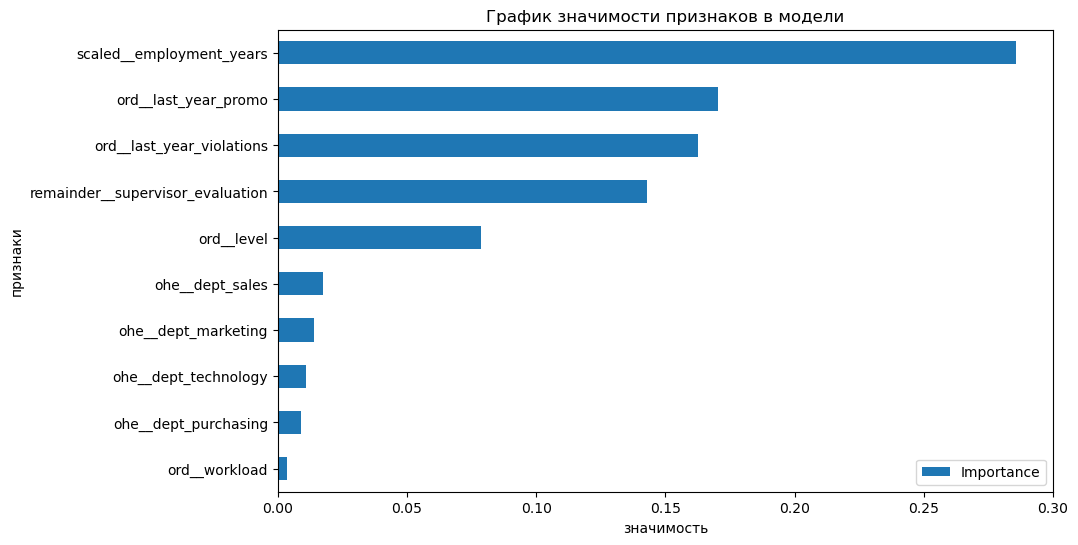

In [126]:
feature_importance = pd.DataFrame({'Feature': pipe_final.named_steps['preprocessor'].get_feature_names_out(), \
                                   'Importance': np.abs(pipe_final.named_steps['models'].coef_)}).sort_values('Importance', ascending=True)


feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

plt.title('График значимости признаков в модели')
plt.xlabel('значимость') 
plt.ylabel('признаки') 

plt.show()

**Модель линейной регрессии**
- Метрика SMAPE на тестовой выборке: 25.63
- Кэффициент детерминации: 0.62
- Дисперсия непостоянна, напоминает рупор

#### Модель дерева решений

In [127]:
X_train = train_job_satisfaction.drop(['id', 'job_satisfaction_rate'], axis=1) 
X_test = test_job_satisfaction.drop(['id', 'job_satisfaction_rate'], axis=1)

scaled_cols.append('salary')

Древовидные модели справляются с мультиколлинеарностью, поэтому для поиска наилучшей модели добавлен мультиколлинеарный признак `salary`

In [128]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', pipe_ohe, ohe_cols),
        ('ord', pipe_ord, ord_cols),
        ('scaled', MinMaxScaler(), scaled_cols)
    ],
    remainder='passthrough'
)


pipe_final = Pipeline([
    ('fillna', preliminary_preprocessor),
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

Переопределен пайплайн, в этап масштабирования добавлен признак `salary`

In [129]:
param_distributions = {
    "models": distributions.CategoricalDistribution([
        DecisionTreeRegressor(random_state=RANDOM_STATE)]),
    
    "models__max_depth": distributions.IntDistribution(3, 60),
    "models__min_samples_split": distributions.IntDistribution(2, 15),
    "models__min_samples_leaf": distributions.IntDistribution(2, 10),
}

In [130]:
# функция для прогресс-бара
def tqdm_callback(study, trial, pbar):
    pbar.update(1)
    if study.best_trial.number == trial.number:
        pbar.set_postfix({"Лучшая метрика SMAPE": f"{-trial.value:.4f}"})

In [131]:
epoch = 50

pbar = tqdm(total=epoch, desc="Поиск параметров Optuna")

oscv = OptunaSearchCV(
    pipe_final,
    param_distributions,
    scoring=smape_score,
    cv=10,
    n_trials=epoch,
    random_state=RANDOM_STATE,
    callbacks=[partial(tqdm_callback, pbar=pbar)]
)

oscv.fit(X_train, y_train)
pbar.close() 

Поиск параметров Optuna:   0%|          | 0/50 [00:00<?, ?it/s]

Лучшие параметры модели: DecisionTreeRegressor(max_depth=27, min_samples_leaf=4, min_samples_split=3,
                      random_state=42)
Лучшая средняя метрика SMAPE на валидации: 14.21
Метрика SMAPE на тестовой выборке: 13.61
Кэффициент детерминации: 0.88


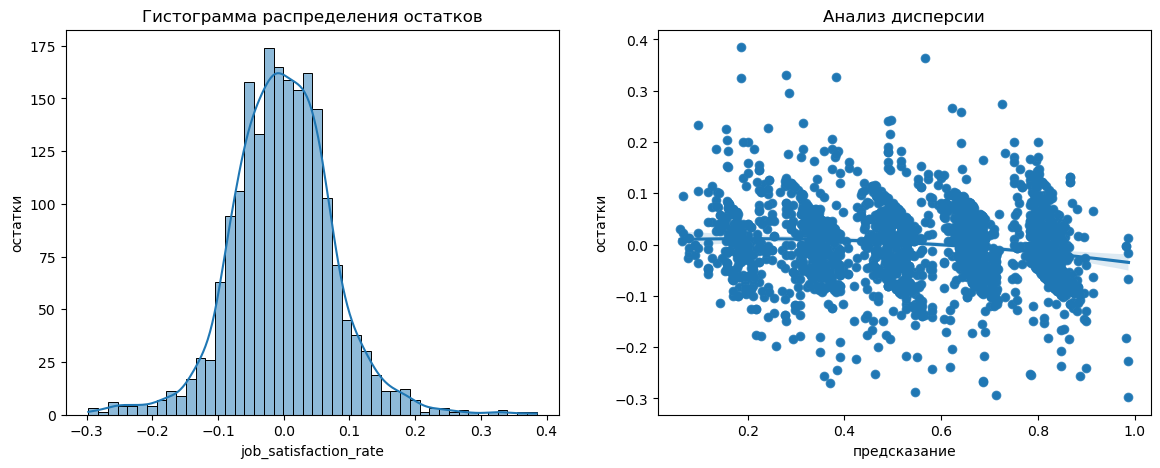

In [132]:
model = oscv.best_estimator_.named_steps['models']
preprocessor = oscv.best_estimator_.named_steps['preprocessor']
fillna_preprocessor = oscv.best_estimator_.named_steps['fillna']


print('Лучшие параметры модели:', oscv.best_params_['models'])
print('Лучшая средняя метрика SMAPE на валидации:', round(-oscv.best_score_, 2))

X_test_scalled = preprocessor.transform(
                            fillna_preprocessor.transform(X_test)
                        )
y_pred = model.predict(X_test_scalled)
print('Метрика SMAPE на тестовой выборке:', round(smape_metric(y_test, y_pred), 2))
print('Кэффициент детерминации:', round(r2_score(y_test, y_pred), 2))

residuals_plot(y_pred, y_test - y_pred)

Также в связи с дисбалансами в двух классах

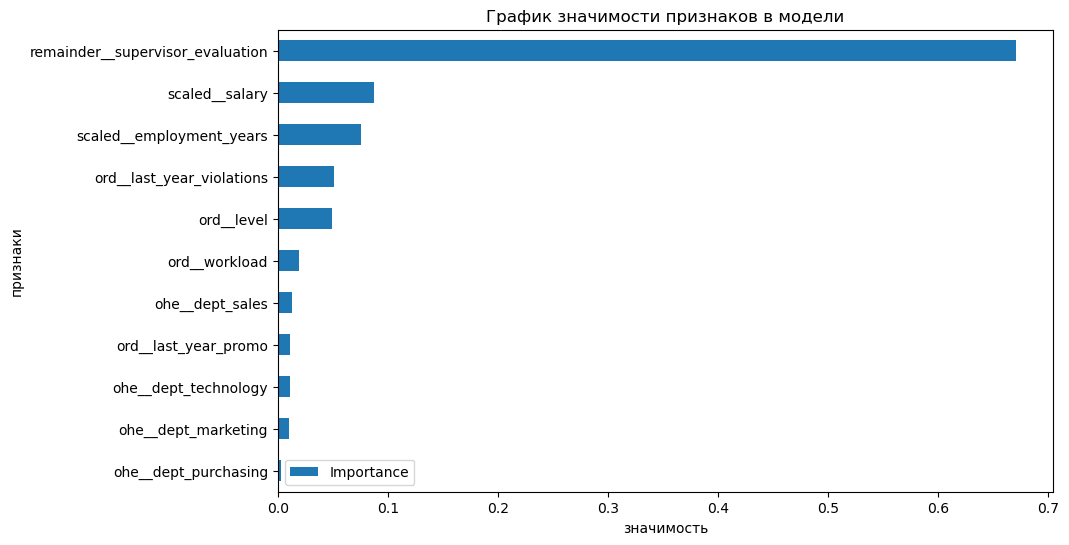

In [133]:
feature_importance = pd.DataFrame({'Feature': preprocessor.get_feature_names_out(), 'Importance': np.abs(model.feature_importances_)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

plt.title('График значимости признаков в модели')
plt.xlabel('значимость') 
plt.ylabel('признаки') 

plt.show()

**Модель дерева решений**

- Параметры лучшей модели: max_depth=27, min_samples_leaf=4, min_samples_split=3
- Лучшая средняя метрика SMAPE на валидации: 14.21
- Метрика SMAPE на тестовой выборке: 13.61
- Кэффициент детерминации: 0.88

Модель имеет высокую предсказательную способность и постоянный разброс дисперсии с кучкованиями, это связано с особенностью модели. В 88% случаев, предсказание модели ближе к истине, чем среднее значение целевого признака.

#### Вывод подготовки данных и обучения модели
Оценка качества работы сотрудника руководителем имеет наибольшую значимость среди всех признаков модели. 

Создан пайплайн для подготовки данных и обучения модели. \
Модель линейной регрессии показала себя хуже, она склонна к ошибкам, её значение SMAPE превышает указанный критерий успеха заказчиком. \
Гиперпараметры модели дерева решений были подобраны, используя байесовскую опитимизацию. Модель имеет высокую предсказательную способность, ей не страшны коллинеарные входные признаки, скорее всего это сыграло большую роль, так как признак `salary` второй по значимости признаков в модели.



## Задача 2: предсказание увольнения сотрудника из компании

### Описание данных
- `id` — уникальный идентификатор сотрудника
- `dept` — отдел, в котором работает сотрудник
- `level` — уровень занимаемой должности
- `workload` — уровень загруженности сотрудника
- `employment_years` — длительность работы в компании (в годах)
- `last_year_promo` — показывает, было ли повышение за последний год
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель
- `salary` — ежемесячная зарплата сотрудника
- `quit` - показывает, уволился ли сотрудник, целевой признак

### Загрузка данных

In [134]:
path_1 = '/datasets/train_quit.csv'
path_2 = './datasets/train_quit.csv'

train_quit = get_dataset(path_1, path_2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,Процент пропусков
id,0.0
dept,0.0
level,0.0
workload,0.0
employment_years,0.0
last_year_promo,0.0
last_year_violations,0.0
supervisor_evaluation,0.0
salary,0.0
quit,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [135]:
unique_category(train_quit)

dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']

level: ['middle' 'junior' 'sinior']

workload: ['high' 'medium' 'low']

last_year_promo: ['no' 'yes']

last_year_violations: ['no' 'yes']

quit: ['no' 'yes']



В датасете **`train_quit`** нет пропущенных значений, неизвестных категорий. Все столбцы имеют названия согласно стандартам оформления.

In [136]:
path_1 = '/datasets/test_target_quit.csv'
path_2 = './datasets/test_target_quit.csv'

test_target_quit = get_dataset(path_1, path_2)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


,Процент пропусков
id,0.0
quit,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [137]:
unique_category(test_target_quit)

quit: ['yes' 'no']



In [138]:
print('Количество id в датасете с целевым столбцом в датасете с входными признаками:', \
    len(test_features.query(f"id in {test_target_quit['id'].tolist()}")))

Количество id в датасете с целевым столбцом в датасете с входными признаками: 2000


Входные признаки из тестовой выборки имеют полную согласованность с новым целевым значением.

#### Вывод загрузки данных

Новый тренировочный набор данных имеет целостность, он не нуждается в предобработке данных. \
Целевой признак является бинарным категориальным, стоит изучить баланс классов.

### Исследовательский анализ данных

In [139]:
train_quit.iloc[:, 1:].describe(include='all')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
count,4000,4000,4000,4000.000000,4000,4000,4000.000000,4000.000000,4000
unique,5,3,3,NaN,2,2,NaN,NaN,2
top,sales,junior,medium,NaN,no,no,NaN,NaN,no
freq,1438,1949,2118,NaN,3887,3455,NaN,NaN,2872
mean,NaN,NaN,NaN,3.701500,NaN,NaN,3.474750,33805.800000,NaN
std,NaN,NaN,NaN,2.541852,NaN,NaN,1.004049,15152.415163,NaN
min,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,NaN
25%,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,NaN
75%,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,NaN


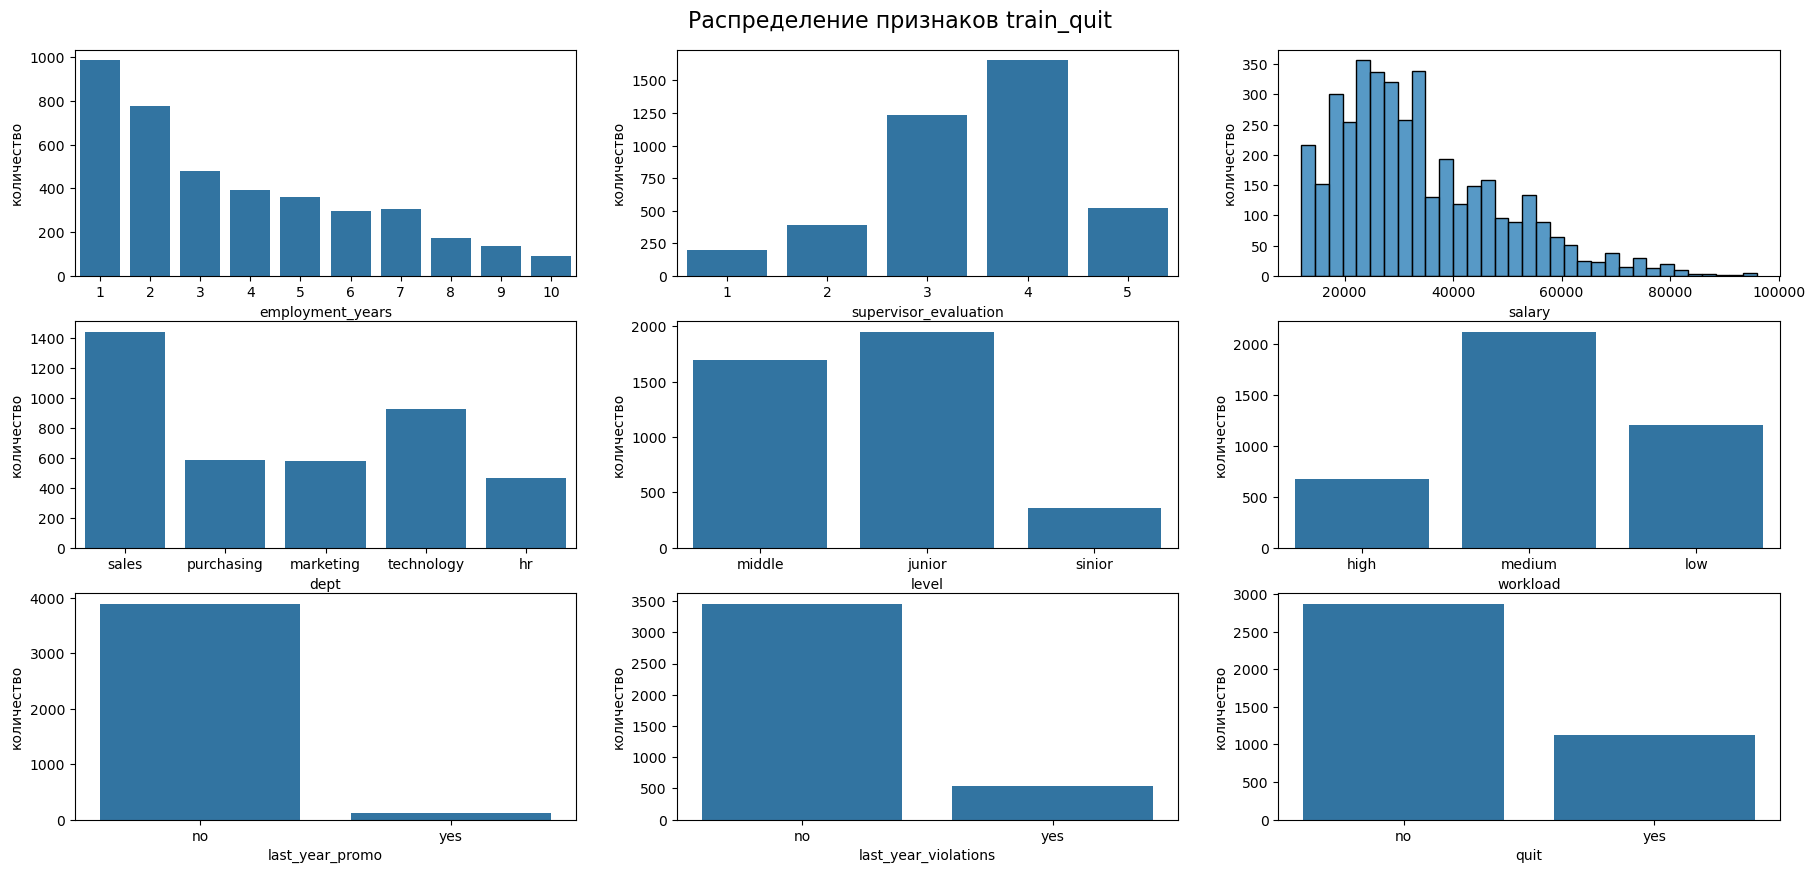

In [140]:
plt_hist(train_quit)
plt.suptitle('Распределение признаков train_quit', y=0.92, fontsize=16)
plt.show()

Тренировочный набор данных для задачи бинарный классификации имеет явный дисбаланс классов целевого признака

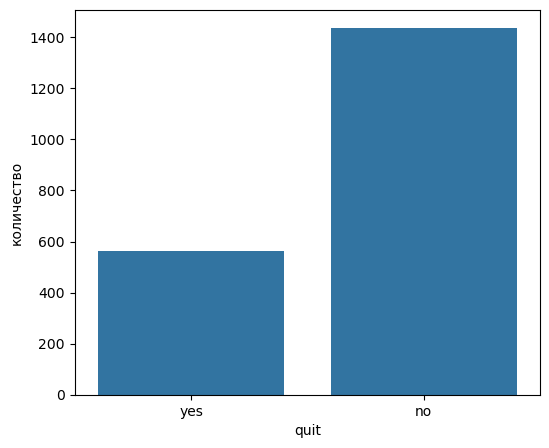

In [141]:
plt.figure(figsize=(6, 5))
sns.countplot(data=test_target_quit, x='quit', color='#1F77B4')
plt.ylabel('количество');

Тестовый набор данных целевого признака **`test_target_quit`** имеет схожее распределение с целевым тренировочного датасета. Но все же стоит применить стратегию для избавления дисбаланса классов, иначе модель будет хорошо определять мажорный класс, часто ошибаясь на минорном.

#### Корреляционный анализ

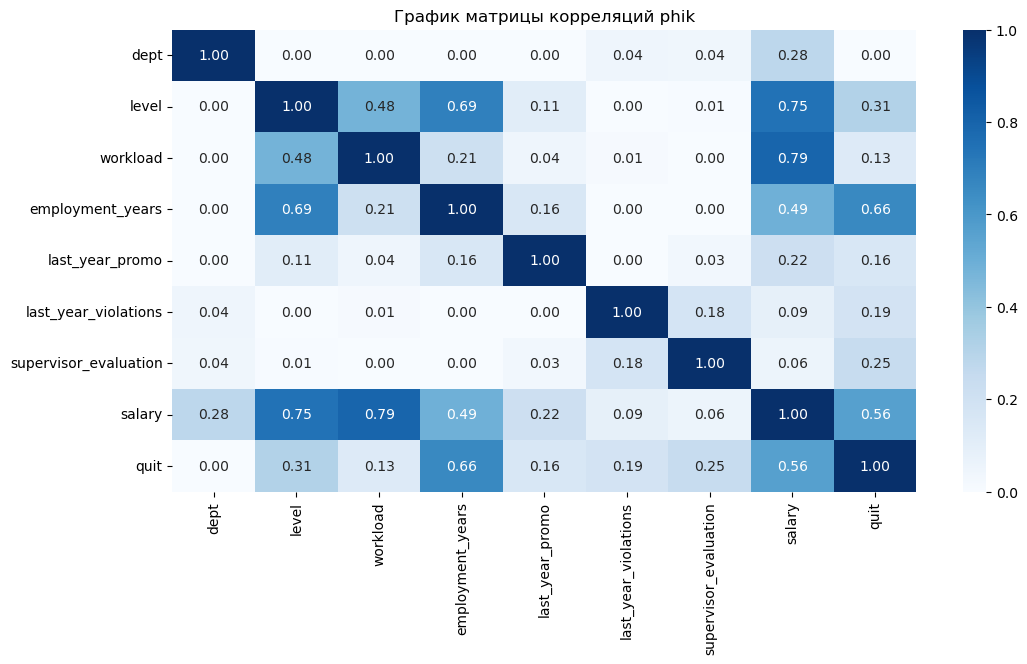

In [142]:
plt.figure(figsize=(12, 6))
plt.title('График матрицы корреляций phik')
sns.heatmap(train_quit.iloc[:, 1:].phik_matrix(interval_cols=['salary']),
            annot=True,
            fmt='.2f',
            cmap='Blues');

1. Мультиколлениарность
    1. Высокая:
        - `workload` и `salary` - 0.79
        - `level` и `salary` - 0.75
    2. Заметная:
        - `level` и `employment_years` - 0.69
    3. Умеренная:
        - `employment_years` и `salary` - 0.49
        - `level` и `workload` - 0.48


2. Связь с целевым:
    1. `employment_years` - 0.66
    2. `salary` - 0.56
    3. `level` - 0.31

#### Портрет уволившегося сотрудника


In [153]:
quit_true = train_quit.query('quit == "yes"')
quit_false = train_quit.query('quit != "yes"')

(quit_false.iloc[:, 1:].describe()).join(quit_true.iloc[:, 1:].describe(), rsuffix='_quit')

,employment_years,supervisor_evaluation,salary,employment_years_quit,supervisor_evaluation_quit,salary_quit
count,2872.000000,2872.000000,2872.000000,1128.000000,1128.000000,1128.000000
mean,4.430710,3.643106,37702.228412,1.844858,3.046099,23885.106383
std,2.544635,0.965295,15218.977339,1.274920,0.973291,9351.599505
min,1.000000,1.000000,12000.000000,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,25200.000000,1.000000,3.000000,16800.000000
50%,4.000000,4.000000,34800.000000,1.000000,3.000000,22800.000000
75%,6.000000,4.000000,46800.000000,2.000000,4.000000,27600.000000
max,10.000000,5.000000,96000.000000,10.000000,5.000000,79200.000000


Сотрудники, проработавшие в компании менее 2 лет склонны к увальнениям. Уволившиеся сотрудники имели меньшую заработную плату.

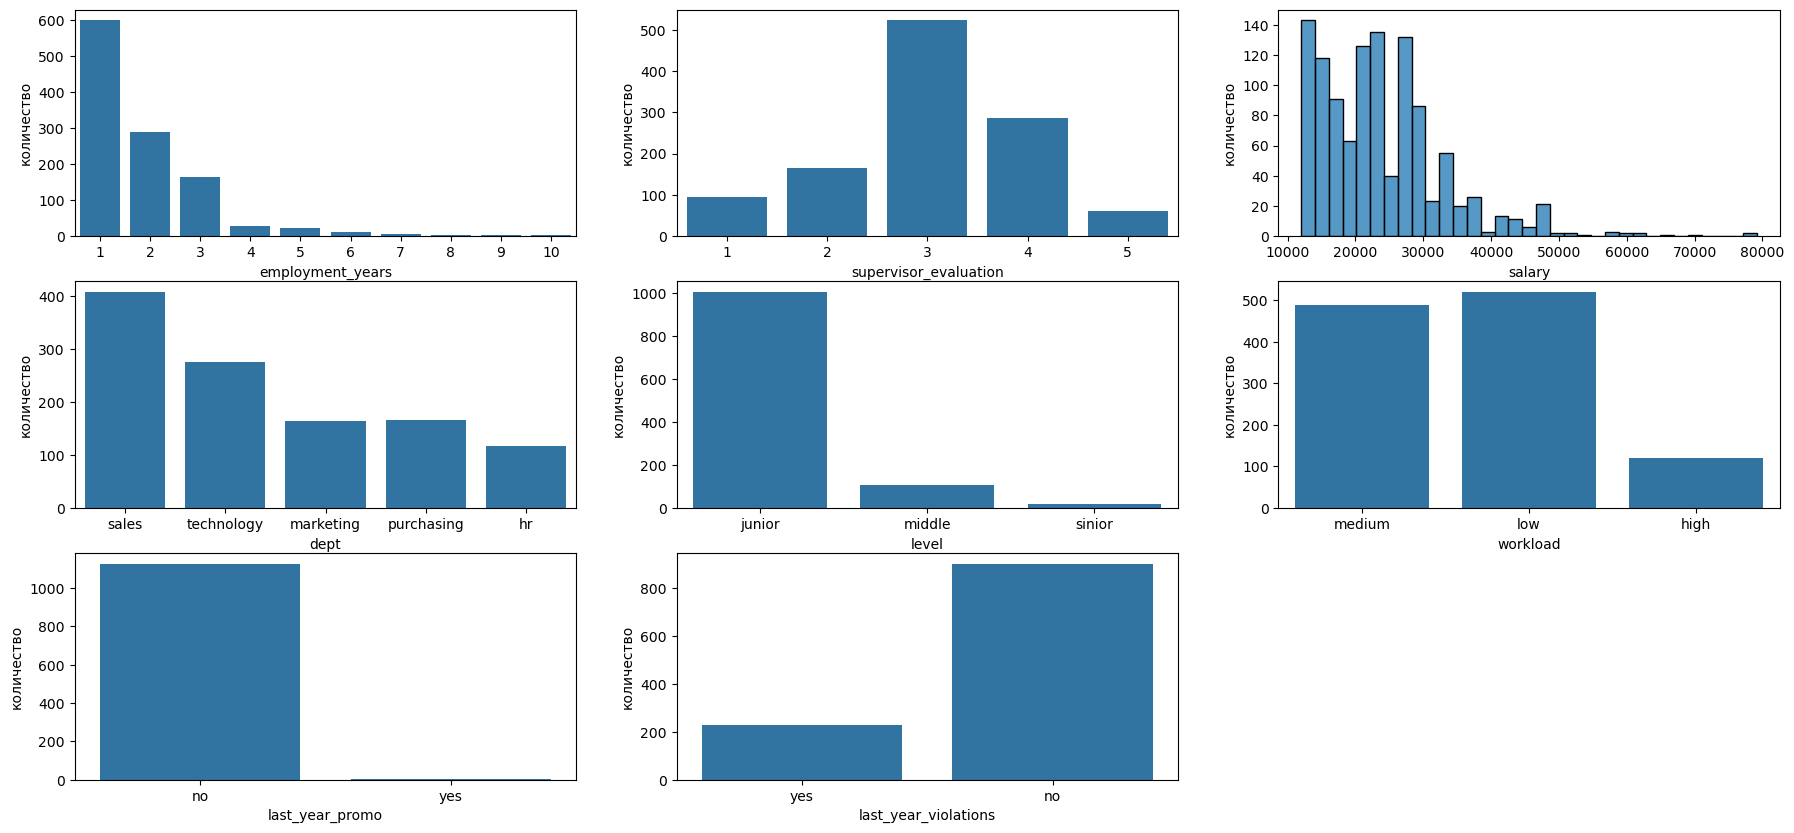

In [156]:
plt_hist(quit_true.iloc[:, :-1])

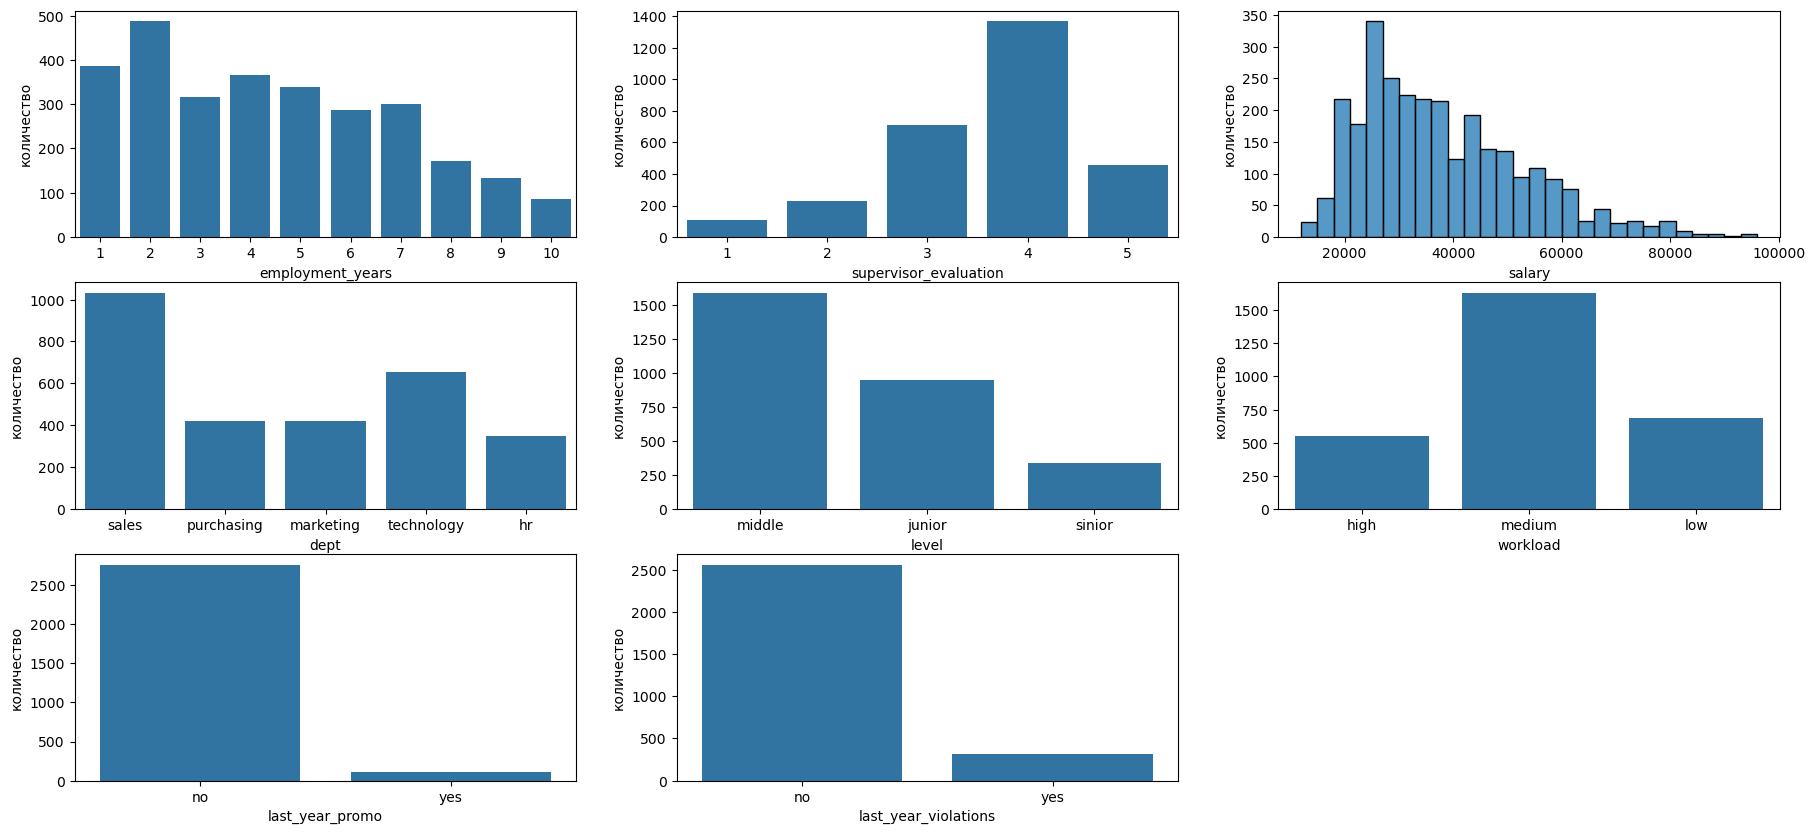

In [155]:
plt_hist(quit_false.iloc[:, :-1])

1. Отдел не имеет влияния на увольнения сотрудников
2. В большинстве случаев, уволившиеся сотрудники имели стаж менее 3-х лет в компании. Но бывали и случаи, когда сотрудники уходили с 10 летним опытом. Такая утечка критична для компании.
3. Уволившиеся сотрудники имеют больший процент по количеству нарушений трудового договора и меньший по количеству повышений.
4. Средняя оценка руководителей для сотрудников у уволившихся меньше, чем у тех, кто продолжает работать в компании

In [184]:
round(quit_false.pivot_table(index=['employment_years', 'workload'], values='salary')
      .join(quit_true.pivot_table(index=['employment_years', 'workload'], values='salary'), rsuffix='_quit'))

salary  salary_quit
employment_years workload                      
1                high      55482.0      37929.0
                 low       20291.0      16702.0
                 medium    29627.0      25994.0
2                high      52600.0      39091.0
                 low       19472.0      16505.0
                 medium    31619.0      27014.0
3                high      59770.0      40743.0
                 low       21316.0      19200.0
                 medium    34844.0      25770.0
4                high      58879.0      51300.0
                 low       23591.0      15467.0
                 medium    36531.0      31440.0
5                high      58165.0      36000.0
                 low       24704.0      20320.0
                 medium    38640.0      43200.0
6                high      59169.0      68400.0
                 low       26172.0      28600.0
                 medium    42710.0      49800.0
7                high      58914.0      48000.0
                 low       25115.0      30600.0
                 medium    43124.0      41100.0
8                high      62188.0      46800.0
                 low       26800.0      24600.0
                 medium    44154.0          NaN
9                high      59829.0      79200.0
                 low       26160.0          NaN
                 medium    44384.0      51600.0
10               high      72415.0          NaN
                 low       30480.0      38400.0
                 medium    47661.0      42000.0

На протяжении 5 лет сотрудники, которые уволились из компании, получали в среднем заработную плату меньше не зависимо от рабочей нагрузки. 